# **Travel Insurance Claims Prediction**

Hi there! this notebook shows the analysis of Team Ceria to create a classification model of travel insurance claims using resampling methods, XGBoost, and Bayesian Optimization. The final result of the best XGBoost model will also be interpreted using feature importance and SHAP.

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
import shap

from pandas_profiling import ProfileReport
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score
from imblearn.over_sampling import *
from imblearn.under_sampling import *
from imblearn.combine import *
from bayes_opt import BayesianOptimization
from xgboost import plot_importance

### **Load Travel Insurance Dataset**

In [6]:
# Original dataset was provided by MASA committee and uploaded to the team's Github repo
travel_df = pd.read_csv('https://raw.githubusercontent.com/matthewfarant/masa_hackathon_2022/main/travel_insurance_dataset.csv?token=GHSAT0AAAAAABWYHOFP5HGVUC7CKTPSKBNUYXYJHAQ')

In [7]:
travel_df.head()

,Agency,Agency Type,Distribution Channel,Product Name,Claim,Duration,Destination,Net Sales,Commision (in value),Gender,Age
0,CBH,Travel Agency,Offline,Comprehensive Plan,No,186,MALAYSIA,-29.0,9.57,F,81
1,CBH,Travel Agency,Offline,Comprehensive Plan,No,186,MALAYSIA,-29.0,9.57,F,71
2,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,No,65,AUSTRALIA,-49.5,29.70,NaN,32
3,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,No,60,AUSTRALIA,-39.6,23.76,NaN,32
4,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,No,79,ITALY,-19.8,11.88,NaN,41


### **Auto-EDA using Pandas Profiling**

The Exploratory Data Analysis (EDA) will be conducted automatically using the Pandas Profiling library. The HTML report generated by this library contains the detailed overview of all the features, missing & duplicated values, correlation matrix, and many more. If you want to see the report, you can **download the travel_insurance_eda.html file** in this repository.

In [ ]:
prof = ProfileReport(travel_df)
prof.to_file(output_file='travel_insurance_eda.html')

Export report to file: 100%|██████████| 1/1 [00:00<00:00, 168.37it/s]


### **Feature Engineering**

After examining the EDA result generated by Pandas Profiling, a feature engineering process that includes data cleaning, data splitting, and handling imbalanced data will be conducted to achieve a better model performance, measured by the ROC-AUC value.

In [103]:
def feature_engineering(df):
    # Replace abnormal age & duration values with NaN. However, more context is needed for these abnormal values.
    df.loc[df['Age']>100,'Age'] = np.NaN
    df.loc[(df['Duration']>1000) | (df['Duration']<0),'Duration'] = np.NaN 
    # Dummy encoding of categorical features
    df = pd.get_dummies(df,drop_first=True)
    # KNN imputation for missing values
    col = df.columns
    imputer = KNNImputer(n_neighbors=2)
    df = pd.DataFrame(imputer.fit_transform(df))
    df.columns = col
    return df

cleaned_df = feature_engineering(travel_df)

### Data Splitting

In this study, an 80:20 split ratio will be used.

In [105]:
def data_splitting(df,target_col,test_size):
    global X, y, X_train, X_test, y_train, y_test
    X = df.loc[:, df.columns != target_col]
    y = df.loc[:, target_col]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size, random_state = 0)

data_splitting(cleaned_df,'Claim_Yes',0.2)

### Imbalanced Data: Claim vs. No Claim

The main problem in this study is the existence of imbalanced data in the target feature. The code below shows that the number of claims is only 1% of the total number of policies. In this study, several methods of oversampling, undersampling, and combination resampling will compared and later be used to tackle this problem.

In [106]:
# 0 = No Claim
# 1 = Claim
cleaned_df['Claim_Yes'].value_counts()

0.0    62399
1.0      927
Name: Claim_Yes, dtype: int64

The comparison is done using the XGBoost ROC-AUC value generated by cross validation score of 5-fold CV. Notice that the resampling process is done **only on training data**. A common mistake is to do the resampling before train-test splitting which generates an almost perfect model, but with misleading results. This phenomenon is usually called "Data Leakage".

In [10]:
model = xgb.XGBRFClassifier(random_state=100)

In [ ]:
# some oversampling methods
over_methods = [
    SMOTE(random_state=100),
    BorderlineSMOTE(random_state=100),
    SVMSMOTE(random_state=100)
]
# cross validation (oversampling)
for methods in over_methods:
  X_train_res, y_train_res = methods.fit_resample(X_train, y_train.ravel())
  score = cross_val_score(model, X_train_res, y_train_res, cv=5, scoring="roc_auc", n_jobs=-1)
  print("The XGB ROC-AUC Mean Score for ",methods," is ",np.mean(score))

The XGB ROC-AUC Mean Score for  SMOTE(random_state=100)  is  0.9137785571469423
The XGB ROC-AUC Mean Score for  BorderlineSMOTE(random_state=100)  is  0.9515687439601501
The XGB ROC-AUC Mean Score for  SVMSMOTE(random_state=100)  is  0.9415471152057411


In [ ]:
# some undersampling methods
under_methods = [
    RandomUnderSampler(random_state=100),
    NearMiss(),
    EditedNearestNeighbours()
]
# cross validation (undersampling)
for methods in under_methods:
  X_train_res, y_train_res = methods.fit_resample(X_train, y_train.ravel())
  score = cross_val_score(model, X_train_res, y_train_res, cv=5, scoring="roc_auc", n_jobs=-1)
  print("The XGB ROC-AUC Mean Score for ",methods," is ",np.mean(score))

The XGB ROC-AUC Mean Score for  RandomUnderSampler(random_state=100)  is  0.8783143306705398
The XGB ROC-AUC Mean Score for  NearMiss()  is  0.8139634874525942
The XGB ROC-AUC Mean Score for  EditedNearestNeighbours()  is  0.7767297528225076


In [11]:
# some combination methods
comb_methods = [
    SMOTEENN(random_state=100),
    SMOTETomek(random_state=100)
]
# cross validation (combination)
for methods in comb_methods:
  X_train_res, y_train_res = methods.fit_resample(X_train, y_train.ravel())
  score = cross_val_score(model, X_train_res, y_train_res, cv=5, scoring="roc_auc", n_jobs=-1)
  print("The XGB ROC-AUC Mean Score for ",methods," is ",np.mean(score))

The XGB ROC-AUC Mean Score for  SMOTEENN(random_state=100)  is  0.9317809676032731


A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


The XGB ROC-AUC Mean Score for  SMOTETomek(random_state=100)  is  0.9123865783176053


From the codes above, we can see which one is the best method for each resampling categories. Next, we will use these three methods to model the claims using XGBoost.

In [107]:
# (Based on above examination)

# Best oversampling
bsm = BorderlineSMOTE(random_state=100)
X_train_res_bsm, y_train_res_bsm = bsm.fit_resample(X_train, y_train.ravel())

# Best undersampling
rus = RandomUnderSampler(random_state=100)
X_train_res_rus, y_train_res_rus = rus.fit_resample(X_train, y_train.ravel())

# Best combination
com = SMOTEENN(random_state=100)
X_train_res_com, y_train_res_com = com.fit_resample(X_train, y_train.ravel())

### **Hyperparameter Tuning using Bayesian Optimization**

Hyperparameter tuning is an essential process in XGBoost modelling due to the numerous parameters that XGBoost has. Contrary to GridSearchCV or Random Search method that people commonly use, Bayesian Optimization doesn't pick the parameters from the hyperparameter space randomly. Instead, it will form a surrogate function to replicate the black-box function of XGBoost ROC-AUC that we want to maximize and sequentially pick the appropriate parameters until the ROC-AUC value is maximized

In [68]:
# Hyperparameter Space
hps = {
  'min_child_weight':(3, 20),
  'gamma':(0, 10),
  'subsample':(0.5, 1),
  'colsample_bytree':(0.1, 1),
  'max_depth': (2, 20),
  'learning_rate': (0, 1)
}

# Base function that will be optimized
def hyper_xgboost(max_depth, subsample, colsample_bytree,min_child_weight, gamma, learning_rate):
    params = {
    'objective': 'binary:logistic',
    'eval_metric':'auc',
    'nthread':-1
     }
    params['max_depth'] = int(round(max_depth))
    params['subsample'] = max(min(subsample, 1), 0)
    params['colsample_bytree'] = max(min(colsample_bytree, 1), 0)
    params['min_child_weight'] = int(min_child_weight)
    params['gamma'] = max(gamma, 0)
    params['learning_rate'] = learning_rate

    scores = xgb.cv(params, dtrain, num_boost_round=500,verbose_eval=False,   #XGBoost requires data to be transformed into DMatrix
                    early_stopping_rounds=10, nfold=5)
    return scores['test-auc-mean'].iloc[-1]

BorderlineSMOTE

In [44]:
# BorderlineSMOTE
dtrain = xgb.DMatrix(X_train_res_bsm, y_train_res_bsm, feature_names=X_train_res_bsm.columns.values)
optimizer = BayesianOptimization(hyper_xgboost, hps, random_state=1)
optimizer.maximize(init_points=2, n_iter=5)

|   iter    |  target   | colsam... |   gamma   | learni... | max_depth | min_ch... | subsample |
-------------------------------------------------------------------------------------------------
|  1        |  0.9818   |  0.4753   |  7.203    |  0.000114 |  7.442    |  5.495    |  0.5462   |
|  2        |  0.9973   |  0.2676   |  3.456    |  0.3968   |  11.7     |  10.13    |  0.8426   |
|  3        |  0.997    |  0.2908   |  3.604    |  0.8477   |  11.16    |  10.07    |  0.6585   |
|  4        |  0.9969   |  0.2957   |  0.2535   |  1.0      |  11.53    |  15.65    |  0.5      |
|  5        |  0.9966   |  0.1303   |  6.76     |  1.0      |  16.69    |  15.6     |  0.5      |
|  6        |  0.9968   |  1.0      |  0.0      |  1.0      |  19.51    |  10.84    |  0.5      |
|  7        |  0.9968   |  1.0      |  0.0      |  1.0      |  20.0     |  20.0     |  0.5052   |


In [45]:
optimizer.max['params']

{'colsample_bytree': 0.2676341902399038,
 'gamma': 3.4556072704304777,
 'learning_rate': 0.39676747423066994,
 'max_depth': 11.698701212060424,
 'min_child_weight': 10.126306744856013,
 'subsample': 0.8426097501983798}

In [71]:
# Based on the best parameter tuning above
params = {
    'colsample_bytree': 0.2676341902399038,
    'gamma': 3.4556072704304777,
    'learning_rate': 0.39676747423066994,
    'max_depth': 12,
    'min_child_weight': 10,
    'subsample': 0.8426097501983798,
    'objective': 'binary:logistic',
    'eval_metric':'auc',
    'n_jobs':-1
}
xgbr_ov =  xgb.XGBClassifier(**params, random_state=100, nthread=-1)
xgbr_ov.fit(X_train_res_bsm, y_train_res_bsm)

XGBClassifier(colsample_bytree=0.2676341902399038, eval_metric='auc',
              gamma=3.4556072704304777, learning_rate=0.39676747423066994,
              max_depth=12, min_child_weight=10, n_jobs=-1, nthread=-1,
              random_state=100, subsample=0.8426097501983798)

In [72]:
y_pred = xgbr_ov.predict(X_test)
testing_accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test,y_pred)
print("Test Accuracy score {0}".format(testing_accuracy))
print("ROC AUC Score {0}".format(roc_auc))
print(classification_report(y_test, y_pred))

Test Accuracy score 0.980050531634909
ROC AUC Score 0.5202395988905484
              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99     18748
         1.0       0.08      0.05      0.06       250

    accuracy                           0.98     18998
   macro avg       0.53      0.52      0.52     18998
weighted avg       0.98      0.98      0.98     18998



RandomUnderSampling

In [108]:
# RandomUnderSampling
dtrain = xgb.DMatrix(X_train_res_rus, y_train_res_rus, feature_names=X_train_res_rus.columns.values)
optimizer = BayesianOptimization(hyper_xgboost, hps, random_state=1)
optimizer.maximize(init_points=2, n_iter=5)

|   iter    |  target   | colsam... |   gamma   | learni... | max_depth | min_ch... | subsample |
-------------------------------------------------------------------------------------------------
|  1        |  0.8199   |  0.4753   |  7.203    |  0.000114 |  7.442    |  5.495    |  0.5462   |
|  2        |  0.819    |  0.2676   |  3.456    |  0.3968   |  11.7     |  10.13    |  0.8426   |
|  3        |  0.8211   |  0.4054   |  7.817    |  0.1203   |  7.538    |  5.589    |  0.9949   |
|  4        |  0.806    |  0.6379   |  3.184    |  0.6631   |  10.07    |  5.927    |  0.6515   |
|  5        |  0.8068   |  0.1075   |  9.696    |  0.02058  |  4.872    |  6.028    |  0.5944   |
|  6        |  0.8209   |  0.8096   |  8.579    |  0.2866   |  9.447    |  5.336    |  0.5578   |
|  7        |  0.8228   |  0.6531   |  8.305    |  0.1256   |  8.591    |  3.011    |  0.9088   |


In [109]:
optimizer.max['params']

{'colsample_bytree': 0.6530757505740343,
 'gamma': 8.304814324499533,
 'learning_rate': 0.12556992929644617,
 'max_depth': 8.590533394055313,
 'min_child_weight': 3.0106534893767374,
 'subsample': 0.9088292575533716}

In [110]:
# Based on the best parameter tuning above
params = {
    'colsample_bytree': 0.6530757505740343,
    'gamma': 8.304814324499533,
    'learning_rate': 0.12556992929644617,
    'max_depth': 9,
    'min_child_weight': 3,
    'subsample': 0.9088292575533716,
    'objective': 'binary:logistic',
    'eval_metric':'auc',
    'n_jobs':-1
}
xgbr_un =  xgb.XGBClassifier(**params, random_state=100, nthread=-1)
xgbr_un.fit(X_train_res_rus, y_train_res_rus)

XGBClassifier(colsample_bytree=0.6530757505740343, eval_metric='auc',
              gamma=8.304814324499533, learning_rate=0.12556992929644617,
              max_depth=9, min_child_weight=3, n_jobs=-1, nthread=-1,
              random_state=100, subsample=0.9088292575533716)

In [111]:
y_pred = xgbr_un.predict(X_test)
testing_accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test,y_pred)
print("Test Accuracy score {0}".format(testing_accuracy))
print("ROC AUC Score {0}".format(roc_auc))
print(classification_report(y_test, y_pred))

Test Accuracy score 0.7587241433759672
ROC AUC Score 0.7463949927864344
              precision    recall  f1-score   support

         0.0       1.00      0.76      0.86     12497
         1.0       0.04      0.73      0.08       169

    accuracy                           0.76     12666
   macro avg       0.52      0.75      0.47     12666
weighted avg       0.98      0.76      0.85     12666



SMOTEENN

In [83]:
# SMOTEENN
dtrain = xgb.DMatrix(X_train_res_com, y_train_res_com, feature_names=X_train_res_com.columns.values)
optimizer = BayesianOptimization(hyper_xgboost, hps, random_state=1)
optimizer.maximize(init_points=2, n_iter=5)

|   iter    |  target   | colsam... |   gamma   | learni... | max_depth | min_ch... | subsample |
-------------------------------------------------------------------------------------------------
|  1        |  0.9772   |  0.4753   |  7.203    |  0.000114 |  7.442    |  5.495    |  0.5462   |
|  2        |  0.9983   |  0.2676   |  3.456    |  0.3968   |  11.7     |  10.13    |  0.8426   |
|  3        |  0.998    |  0.2908   |  3.604    |  0.8477   |  11.16    |  10.07    |  0.6585   |
|  4        |  0.9979   |  0.3302   |  0.2223   |  1.0      |  11.33    |  15.57    |  0.5      |
|  5        |  0.9975   |  0.2118   |  6.783    |  1.0      |  16.23    |  15.93    |  0.5      |
|  6        |  0.9982   |  1.0      |  0.0      |  1.0      |  19.64    |  11.36    |  0.5      |
|  7        |  0.9981   |  1.0      |  0.0      |  1.0      |  20.0     |  20.0     |  0.5025   |


In [84]:
optimizer.max['params']

{'colsample_bytree': 0.2676341902399038,
 'gamma': 3.4556072704304777,
 'learning_rate': 0.39676747423066994,
 'max_depth': 11.698701212060424,
 'min_child_weight': 10.126306744856013,
 'subsample': 0.8426097501983798}

In [87]:
# Based on the best parameter tuning above
params = {
    'colsample_bytree': 0.2676341902399038,
    'gamma': 3.4556072704304777,
    'learning_rate': 0.39676747423066994,
    'max_depth': 12,
    'min_child_weight': 10,
    'subsample': 0.8426097501983798,
    'objective': 'binary:logistic',
    'eval_metric':'auc',
    'n_jobs':-1
}
xgbr_com =  xgb.XGBClassifier(**params, random_state=100, nthread=-1)
xgbr_com.fit(X_train_res_com, y_train_res_com)

XGBClassifier(colsample_bytree=0.2676341902399038, eval_metric='auc',
              gamma=3.4556072704304777, learning_rate=0.39676747423066994,
              max_depth=12, min_child_weight=10, n_jobs=-1, nthread=-1,
              random_state=100, subsample=0.8426097501983798)

In [88]:
y_pred = xgbr_com.predict(X_test)
testing_accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test,y_pred)
print("Test Accuracy score {0}".format(testing_accuracy))
print("ROC AUC Score {0}".format(roc_auc))
print(classification_report(y_test, y_pred))

Test Accuracy score 0.9659964206758607
ROC AUC Score 0.5802120759547684
              precision    recall  f1-score   support

         0.0       0.99      0.98      0.98     18748
         1.0       0.09      0.18      0.12       250

    accuracy                           0.97     18998
   macro avg       0.54      0.58      0.55     18998
weighted avg       0.98      0.97      0.97     18998



From the three results above, we can conclude that RandomUnderSampling will generate the highest ROC-AUC score among the other methods. Even though the accuracy score is not the highest, the main thing that is focused in this study is the ability of the model to predict the minority class (claims).

In [112]:
# After re-running xgb modelling for RandomUnderSampling
print(confusion_matrix(y_test,y_pred))

[[9486 3011]
 [  45  124]]


From the confusion matrix above, we can see that the model has a 76% acurracy and 73% recall, which is a good thing since in cost-sensitive learning, a conservative model is needed. On other words, since the cost of false negative (wrongly predict someone is not claiming) is **higher** than the cost of false positive (wrongly predict someone is claiming), a high recall is a good news.

### **Model Interpretation**

Below is a feature importance plot of the XGBoost model. In this plot, we can see which features are the most significant predictors of whether a policyholder files a claim. It is shown that Net Sales, Duration, Age, Agency_C2B, and Product Name_Cancellation Plan are among the top 5 features.

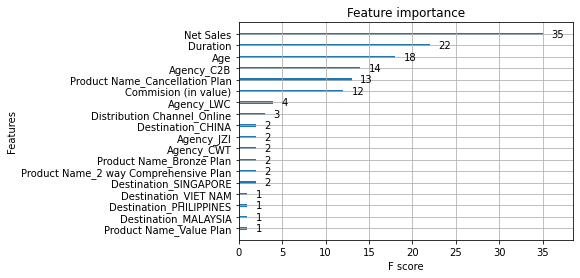

In [113]:
# XGBoost Feature Importance
plot_importance(xgbr_un)
plt.show()

As an additional analysis to see the dynamic significance of each individual data to the prediction, a SHAP summary plot is also generated below. Some of the results below are also confirming the feature importance above.

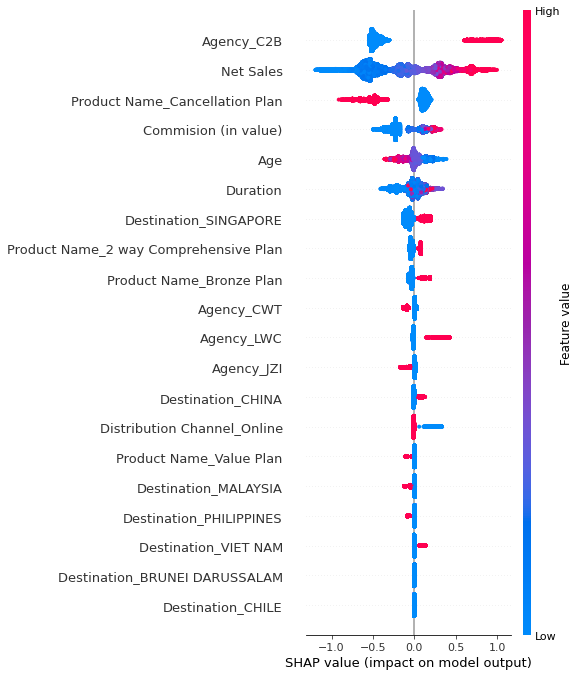

In [114]:
shap_values = shap.TreeExplainer(xgbr_un).shap_values(X)
shap.summary_plot(shap_values, X)

That's it folks! A detailed explanation of our analysis will be written in the business proposal. Thank you :smile: